<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_PyTorchTraining/blob/main/IG_DenoisingAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from keras.datasets import mnist

In [200]:
(x_train, _), (x_test, _) = mnist.load_data()

In [201]:
x_train.shape

(60000, 28, 28)

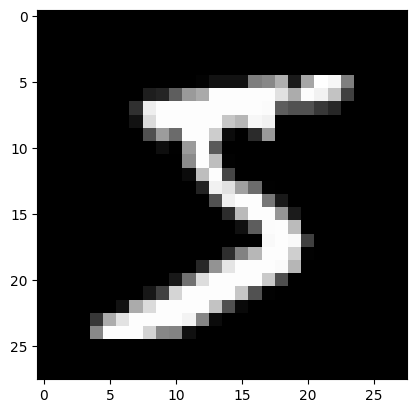

In [202]:
plt.imshow(x_train[0], cmap="gray")
plt.show()

In [203]:
x_train, x_test = x_train/255., x_test/255.

In [205]:
x_train = np.reshape(x_train, (x_train.shape[0], 1,28,28))
x_test = np.reshape(x_test, (x_test.shape[0], 1,28,28))

In [206]:
noise_threshold = 0.2
x_train_noisy = x_train + noise_threshold * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_threshold * np.random.normal(size=x_test.shape)

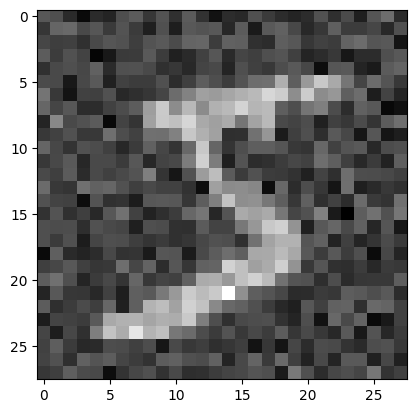

In [219]:
plt.imshow(x_train_noisy[0].reshape(28,28,1), cmap="gray")
plt.show()

In [ ]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

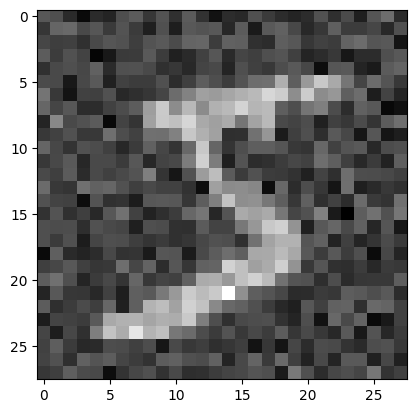

In [220]:
plt.imshow(x_train_noisy[0].reshape(28,28,1), cmap="gray")
plt.show()

In [209]:
class DenoisingAE(nn.Module):
  def __init__(self):
    super().__init__()
    # DownSampling
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, (3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Conv2d(32, 64, (3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Conv2d(64, 128, (3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )

    # UpSampling
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 128, (3,3), stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, (2,2), stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, (2,2), stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, (1,1), stride=1, padding=0),
        nn.Sigmoid()
    )

  def forward(self, images):
    x = self.encoder(images)
    x = self.decoder(x)
    return x

In [210]:
model = DenoisingAE()

In [211]:
from torchsummary import summary

In [212]:
summary(model, input_size=(1,28,28),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10            [-1, 128, 7, 7]         147,584
             ReLU-11            [-1, 128, 7, 7]               0
  ConvTranspose2d-12           [-1, 64, 14, 14]          32,832
             ReLU-13           [-1, 64, 14, 14]               0
  ConvTranspose2d-14           [-1, 32,

In [213]:
type(x_train_noisy)

numpy.ndarray

In [214]:
x_train_data = torch.from_numpy(x_train_noisy).type(torch.float)
x_test_data = torch.from_numpy(x_test_noisy).type(torch.float)

In [215]:
x_train_data.shape

torch.Size([60000, 1, 28, 28])

In [216]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x_train_data = x_train_data.to(device)
x_test_data = x_test_data.to(device)

In [217]:
trainLoader = DataLoader(x_train_data, batch_size=32, shuffle=True)
testLoader = DataLoader(x_test_data, batch_size=32, shuffle=True)

In [223]:
from tqdm import tqdm

model = DenoisingAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

train_loss = []
epochs = 20
for epoch in tqdm(range(epochs)):
  running_loss = 0.0
  for data in trainLoader:
    img = data
    img = img.to(device)
    optimizer.zero_grad()
    output = model(img)
    loss = loss_fn(output, img)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss = running_loss / len(trainLoader)
  train_loss.append(loss)
  print("Epoch : {}, Train Loss : {}".format(epoch,loss))


  5%|▌         | 1/20 [00:06<02:05,  6.61s/it]

Epoch : 0, Train Loss : 0.08112150006492932


 10%|█         | 2/20 [00:12<01:55,  6.44s/it]

Epoch : 1, Train Loss : 0.05301569534142812


 15%|█▌        | 3/20 [00:19<01:50,  6.50s/it]

Epoch : 2, Train Loss : 0.04851287020246188


 20%|██        | 4/20 [00:25<01:43,  6.49s/it]

Epoch : 3, Train Loss : 0.04650200234254201


 25%|██▌       | 5/20 [00:32<01:37,  6.49s/it]

Epoch : 4, Train Loss : 0.04527508776982625


 30%|███       | 6/20 [00:39<01:31,  6.53s/it]

Epoch : 5, Train Loss : 0.044470929757754005


 35%|███▌      | 7/20 [00:45<01:23,  6.46s/it]

Epoch : 6, Train Loss : 0.04388099200328191


 40%|████      | 8/20 [00:51<01:18,  6.50s/it]

Epoch : 7, Train Loss : 0.04341080150405566


 45%|████▌     | 9/20 [00:58<01:10,  6.43s/it]

Epoch : 8, Train Loss : 0.043032073537508646


 50%|█████     | 10/20 [01:04<01:04,  6.46s/it]

Epoch : 9, Train Loss : 0.04269499277472496


 55%|█████▌    | 11/20 [01:11<00:57,  6.43s/it]

Epoch : 10, Train Loss : 0.04241091425816218


 60%|██████    | 12/20 [01:17<00:51,  6.49s/it]

Epoch : 11, Train Loss : 0.04214976324836413


 65%|██████▌   | 13/20 [01:24<00:45,  6.43s/it]

Epoch : 12, Train Loss : 0.04190036448637644


 70%|███████   | 14/20 [01:30<00:38,  6.48s/it]

Epoch : 13, Train Loss : 0.04167571792602539


 75%|███████▌  | 15/20 [01:36<00:32,  6.42s/it]

Epoch : 14, Train Loss : 0.041452750903367995


 80%|████████  | 16/20 [01:43<00:26,  6.61s/it]

Epoch : 15, Train Loss : 0.041243908844391504


 85%|████████▌ | 17/20 [01:50<00:19,  6.53s/it]

Epoch : 16, Train Loss : 0.041044442107280095


 90%|█████████ | 18/20 [01:56<00:13,  6.53s/it]

Epoch : 17, Train Loss : 0.0408532801647981


 95%|█████████▌| 19/20 [02:03<00:06,  6.46s/it]

Epoch : 18, Train Loss : 0.04066662767529488


100%|██████████| 20/20 [02:09<00:00,  6.49s/it]

Epoch : 19, Train Loss : 0.040490645654996237


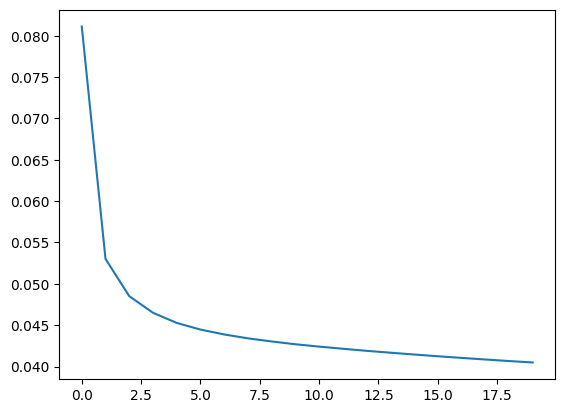

In [224]:
plt.plot(train_loss)
plt.show()